In [1]:
# Import required packages 
import tensorflow as tf
import image_modeling   # import image_modeling.py file
import tensorflow_hub as hub
import datetime
import csv
import numpy as np
import pandas as pd
# Load the TensorBoard notebook extension
%load_ext tensorboard

/Users/lee/neuefische/Capstone_Project_Turtle_Recall/.venv/lib/python3.9/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
# Clear any logs from previous runs
!rm -rf ./logs/

In [3]:
# Import variables from image_modelling.py file
file = open("../data/test.csv")
reader = csv.reader(file)

HEIGHT = image_modeling.HEIGHT
WIDTH = image_modeling.WIDTH
NCLASSES = image_modeling.NCLASSES
CLASS_NAMES = image_modeling.CLASS_NAMES
BATCH_SIZE = image_modeling.BATCH_SIZE
TRAINING_SIZE = image_modeling.TRAINING_SIZE
TRAINING_STEPS = (TRAINING_SIZE // BATCH_SIZE)

## NEU AB HIER

In [ ]:
#!python -m pip install -U scikit-image

In [4]:
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, exposure

In [5]:
train_datagen, test_datagen = image_modeling.preprocess()
train_generator, validation_generator = image_modeling.use_image_generator2(train_datagen, test_datagen, training=True)
#test_generator = image_modeling.use_image_generator(train_datagen, test_datagen, training=False)

Found 1502 validated image filenames.
Found 643 validated image filenames.


/Users/lee/neuefische/Capstone_Project_Turtle_Recall/.venv/lib/python3.9/site-packages/keras_preprocessing/image/dataframe_iterator.py:219: UserWarning: `classes` will be ignored given the class_mode="None"
  warnings.warn('`classes` will be ignored given the class_mode="{}"'


In [34]:
def get_hog_list(images_in_batches):    
    hog_images = []
    _ = 0
    for i in range(len(images_in_batches)):
        for j in range(BATCH_SIZE):
            fd, bilder = hog(images_in_batches[i][j], orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), channel_axis=-1, visualize=True)
            hog_images.append(fd)
            _ += 1
            if _ >= images_in_batches.samples:
                break
    return hog_images, bilder

In [49]:
#test
images_in_batches = train_generator
hog_images = []
_ = 0
for i in range(len(images_in_batches)):
    for j in range(BATCH_SIZE):
        fd, bilder = hog(images_in_batches[i][j], orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), channel_axis=-1, visualize=True)
        hog_images.append(fd)
        print(bilder.shape, i, j)
        _ += 1
        if _ >= 1:
            break


(224, 224) 0 0
(224, 224) 1 0
(224, 224) 2 0
(224, 224) 3 0
(224, 224) 4 0
(224, 224) 5 0
(224, 224) 6 0
(224, 224) 7 0
(224, 224) 8 0
(224, 224) 9 0
(224, 224) 10 0
(224, 224) 11 0
(224, 224) 12 0
(224, 224) 13 0
(224, 224) 14 0
(224, 224) 15 0
(224, 224) 16 0
(224, 224) 17 0
(224, 224) 18 0
(224, 224) 19 0
(224, 224) 20 0
(224, 224) 21 0
(224, 224) 22 0
(224, 224) 23 0
(224, 224) 24 0
(224, 224) 25 0
(224, 224) 26 0
(224, 224) 27 0
(224, 224) 28 0
(224, 224) 29 0
(224, 224) 30 0
(224, 224) 31 0
(224, 224) 32 0
(224, 224) 33 0
(224, 224) 34 0
(224, 224) 35 0
(224, 224) 36 0
(224, 224) 37 0
(224, 224) 38 0
(224, 224) 39 0
(224, 224) 40 0
(224, 224) 41 0
(224, 224) 42 0
(224, 224) 43 0
(224, 224) 44 0
(224, 224) 45 0
(224, 224) 46 0


In [ ]:
train_hog, bilder = get_hog_list(train_generator)
validation_hog, bilder = get_hog_list(validation_generator)

In [14]:
train_labels_list = image_modeling.train_labels_list
validation_labels_list = image_modeling.validation_labels_list

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
model = LinearSVC()
model.fit(train_hog, train_labels_list)
#%% Evaluate the classifier
print(" Evaluating classifier on test data ...")
predictions = model.predict(validation_hog)
print(classification_report(validation_labels_list, predictions))

In [44]:
bilder.shape

(224, 224)

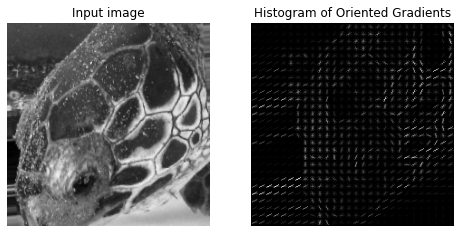

In [50]:


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(train_generator[46][0], cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(bilder, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()



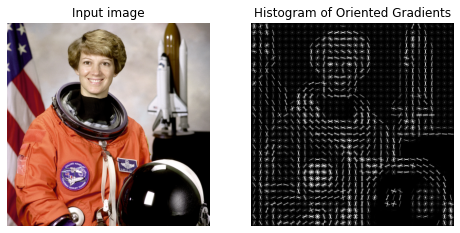

[[[154 147 151]
  [109 103 124]
  [ 63  58 102]
  ...
  [127 120 115]
  [120 117 106]
  [125 119 110]]

 [[177 171 171]
  [144 141 143]
  [113 114 124]
  ...
  [127 118 112]
  [124 115 108]
  [121 116 105]]

 [[201 194 193]
  [182 178 175]
  [168 165 164]
  ...
  [128 120 117]
  [126 116 112]
  [124 114 109]]

 ...

 [[186 170 176]
  [186 170 177]
  [183 168 170]
  ...
  [  0   0   0]
  [  0   0   1]
  [  0   0   0]]

 [[183 169 170]
  [182 167 171]
  [185 164 176]
  ...
  [  0   0   1]
  [  1   1   1]
  [  0   0   0]]

 [[184 167 172]
  [183 165 169]
  [180 162 171]
  ...
  [  0   0   0]
  [  1   1   1]
  [  0   0   0]]]


In [40]:
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, exposure


image = data.astronaut()

fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, channel_axis=-1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

print(image)